[Previously](), I implemented the bayesian version of the OC4 empirical chlorophyll algorithm, where the input consists in the log of the ratio of the maximum of three blue bands to a green band.
Here I will focus on the OC4 algorithm, part of the OCx family of empirical algorithms, which are  generally expressed as follows.
$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

However, some diagnostics of the model results suggested that a $4^{th}$ order polynomial may be too complex.
In this post I compare this model to a simpler $3^{rd}$ order polynomial regression in an attempt to determine which model is more appropriate. For this I use a number of tools including posterior predictive checks on training as well as unseen data, information criteria measures, as well as bayes factor. The goal is to illustrate the importance of not relying on a single scoring methods to assess the performance of a model.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from scipy.stats import norm
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error, r2_score
from theano import shared

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
%matplotlib inline

In [82]:
## HELPER FUNCTIONS
# ---------------------------------------------------

def FitPoly(X,y, order=4, lin=False):
    """
    Numpy regression. Returns coeffs.
    kwargs:
        lin: specifies whether data is log transformed. Data is log transformed if not."""
    if lin:
        X = np.log10(X)
        y = np.log10(y)
    coeffs = np.polyfit(X,y,deg=order)
    return coeffs[::-1]

def GetPPC(data, mcChain, pmModel):
    ppcTrain = pm.sample_ppc(mcChain, samples=1000, model=pmModel)
    # sample posterior predictive check for 50% and 95% density interval
    idx = np.argsort(data)
    sig0 = pm.hpd(ppcTrain['chlPred'], alpha=0.5)[idx] 
    sig1 = pm.hpd(ppcTrain['chlPred'], alpha=0.05)[idx]
    return sig0, sig1

def PlotPPC(data, chlObs, sig0, sig1, bayesCoeffs, oc4V6Coeffs=[], myOLS_coeffs=[],
           title='PPC', ax=None):
    idx = np.argsort(data)
    data_ord = data[idx]
    dataMock = np.linspace(data.min(),data.max(),100)
    chlBayes=0
    for i,coeff in enumerate(bayesCoeffs):
        chlBayes += coeff * dataMock**i
    if not ax:
        f,ax = pl.subplots(figsize=(16,10))
    ax.fill_between(data_ord, sig0[:,0], sig0[:,1], color='k', alpha=1, label='50% HPD.')
    ax.fill_between(data_ord, sig1[:,0], sig1[:,1], color='darkgray', alpha=0.5, label='95% HDP')
    ax.plot(data, chlObs, 'ko', alpha=0.5, markeredgecolor='k',  label='Observation')
    if len(oc4V6Coeffs)>0:
        oc4V6Modl=0
        for i, coef in enumerate(oc4V6Coeffs):
            oc4V6Modl += coef * dataMock**i
        ax.plot(dataMock, oc4V6Modl,'r', linewidth=3, linestyle='--', label='OC4v6')
    if len(myOLS_coeffs)>0:
        olsMdl=0
        for i,coeff in enumerate(myOLS_coeffs[::-1]):
            olsMdl+= coeff * dataMock**i
        pl.plot(dataMock, olsMdl,'m', linewidth=5, label='OLS')
    ax.plot(dataMock, chlBayes,'b', linewidth=2, label='Bayesian OC4')
    ax.set_xlabel(r'$log_{10}\frac{max(Rrs\left(\lambda_{blue}\right))}{Rrs\left(\lambda_{green}\right)}$', fontsize=20)
    ax.set_ylabel(r'$log_{10}\left(chlor_a\right)$', fontsize=20);
    ax.legend(fontsize=14);
    ax.set_title(title);
    return pl.gca()

In [3]:
dfNomadV2 = pd.read_pickle('./bayesianChl_DATA/NOMADV2SWFClean.pkl')

Note the apparent strong collinearity among the reflectances. Also the data appears mostly lognormally distributed (*cf. also Campbell et al, 1995*). I'll next create a maxBlue column, and Blue2GreenRatio column. Then I'll log tranform the blue2green ratio and the chlorophyll data put that in a new dataframe. I'll keep the id column in case I need to determine the origin of a particular observation.

In [4]:
dfNomadV2['maxBlue'] = dfNomadV2.loc[:, ['rrs443','rrs489','rrs510']].max(axis=1)
dfNomadV2['blue2green'] = dfNomadV2.maxBlue / dfNomadV2.rrs555
dfLogOCx = pd.DataFrame(columns=['id','mxBl2Gr', 'chl',])
dfLogOCx['id'] = dfNomadV2.id
dfLogOCx['mxBl2Gr'] = np.log10(dfNomadV2.blue2green.values)
dfLogOCx['chl'] = np.log10(dfNomadV2.chl_all.values)

And let's inspect the data again

In [5]:
dfLogOCx.info(),dfLogOCx.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 3 columns):
id         1016 non-null int32
mxBl2Gr    1016 non-null float64
chl        1016 non-null float64
dtypes: float64(2), int32(1)
memory usage: 27.8 KB


(None,                 id      mxBl2Gr          chl
 count  1016.000000  1016.000000  1016.000000
 mean   4598.373031     0.117382     0.089204
 std    2318.828613     0.287944     0.702093
 min    1441.000000    -0.353183    -1.769551
 25%    2118.750000    -0.087723    -0.456596
 50%    3702.500000     0.021409     0.068000
 75%    7036.250000     0.255020     0.574263
 max    7831.000000     0.982648     1.891341)

As a reminder, the data look like so...

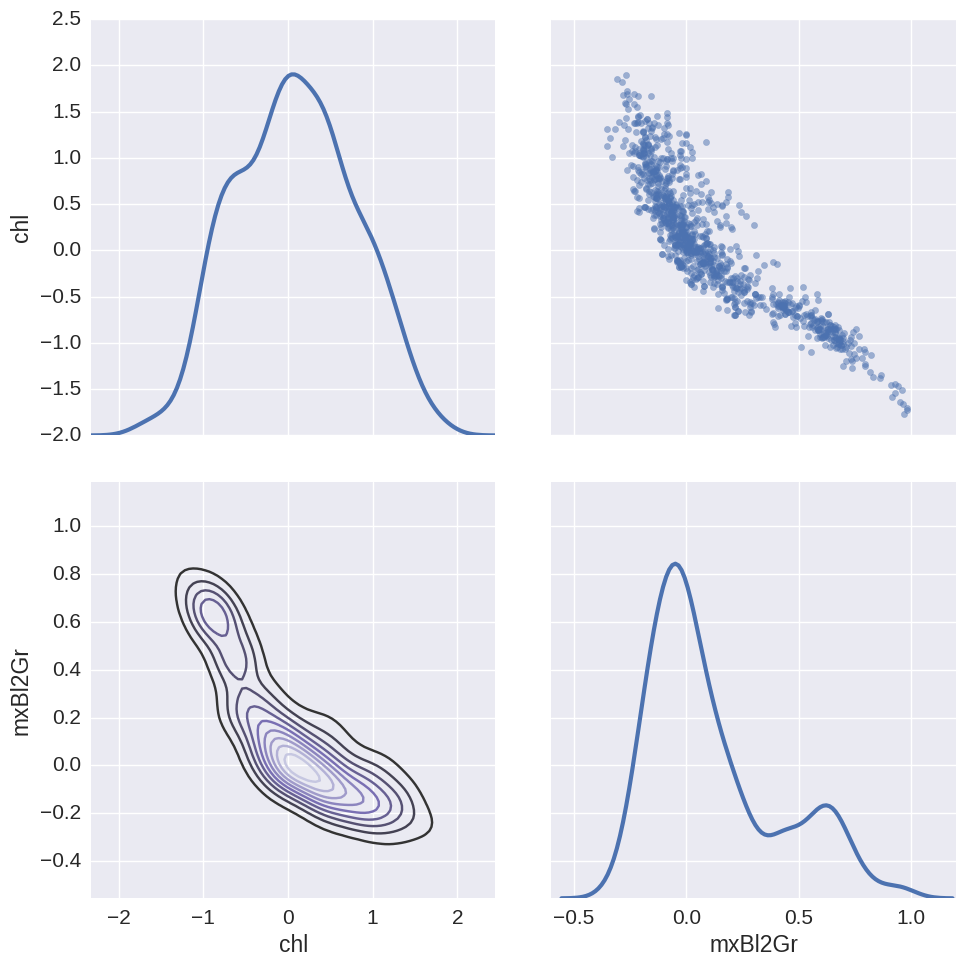

In [6]:
sb.set(font_scale=1.5)
g = sb.PairGrid(dfLogOCx, vars=['chl', 'mxBl2Gr'],size=5, diag_sharey=False);
g = g.map_upper(pl.scatter,alpha=0.5)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(sb.kdeplot, cmap="Purples_d");
#g.axes[0,0].set_xticks(np.arange(-0.5,1.5,0.5));

I'll compute OLS coefficients for polynomials of degree 3 and 4 for reference. Note that I define X_train, y_train here as well, this is in contrast to the testing data that I will later assign to X_test and y_test

In [7]:
X_train = dfLogOCx.mxBl2Gr.values
y_train = dfLogOCx.chl.values
ols3 = FitPoly(X_train, y_train, order=3, lin=False)
ols4 = FitPoly(X_train, y_train, order=4, lin=False)

Bayesian linear regression.
For now, I am simply going to assume I'm still looking for a $4^{th}$ order polynomial. Model comparison will be the subject of a subsequent post.
First I have to specify some priors around the coefficients. I'll assume weakly informative gaussian priors. Before deciding an appropriate distribution for the likelihood, I will check the normality of the  data by way of a normality plot, as well as a comparison between the cummulative distribution function (CDF) of the data and a normal standard distribution.

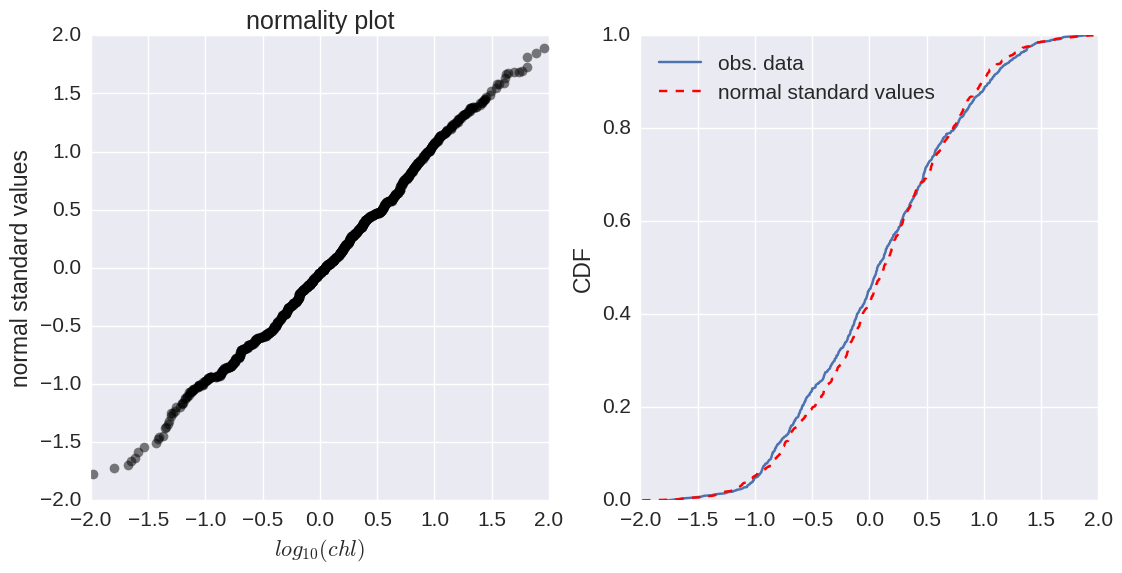

In [8]:
normData = norm.rvs(y_train.mean() ,y_train.std(),
                    size=y_train.size)
normDataSort = np.sort(normData)
logChlSort = np.sort(y_train)
f,ax = pl.subplots(ncols=2,figsize=(13,6))
lbl = r'$log_{10}(chl)$'
ax[0].plot(normDataSort, logChlSort,'ko', alpha=0.5)
ax[0].set_xlabel('%s' %lbl, fontsize=16)
ax[0].set_ylabel('normal standard values');
ax[0].set_title('normality plot')
ax[1].plot(logChlSort, np.linspace(0,1,logChlSort.size), label='obs. data')
ax[1].plot(normDataSort,np.linspace(0,1,normDataSort.size),'r--', 
          label='normal standard values')
ax[1].set_ylabel('CDF')
ax[1].legend(loc='best');

The above suggests that a normal distribution might be a good candidate to apply to the likelihood.
Next is to setup the bayesian model. I'll do the fourth order first and then third order. Note how the input data is cast as a [theano shared variable](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables).  This is not necessary to run the model below. I'll revisit why I do this later when I start playing with the model.

In [9]:
X_Shrd = shared(X_train)

In [10]:
with pm.Model() as OC4_ord4:
    a0 = pm.Normal('a0', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    a4 = pm.Normal('a4', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * X_Shrd + a2 * X_Shrd**2 + a3 * X_Shrd**3 + a4 * X_Shrd**4
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord4 = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 203.732359
         Iterations: 19
         Function evaluations: 28
         Gradient evaluations: 28


100%|██████████| 10000/10000 [01:49<00:00, 91.13it/s]


In [11]:
with pm.Model() as OC4_ord3:
    a0 = pm.Normal('a0', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * X_Shrd + a2 * X_Shrd**2 + a3 * X_Shrd**3
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord3 = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 201.870494
         Iterations: 20
         Function evaluations: 28
         Gradient evaluations: 28


100%|██████████| 10000/10000 [00:44<00:00, 223.64it/s]


In [12]:
# remove some burn-in
chain_ord4 = trace_ord4[1000:]
chain_ord3 = trace_ord3[1000:]
varnames_o4=['a%d' %d for d in range(5)]
varnames_o3=['a%d' %d for d in range(4)]
varnames_o4.append('epsilon')
varnames_o3.append('epsilon')

I've already examined the diagnostics in the [last post](). I will do the same now for the order 3 polynomial, just to make sure the model convergence was good.

#### Order 3 Polynomial Regression Inference Diagnoses

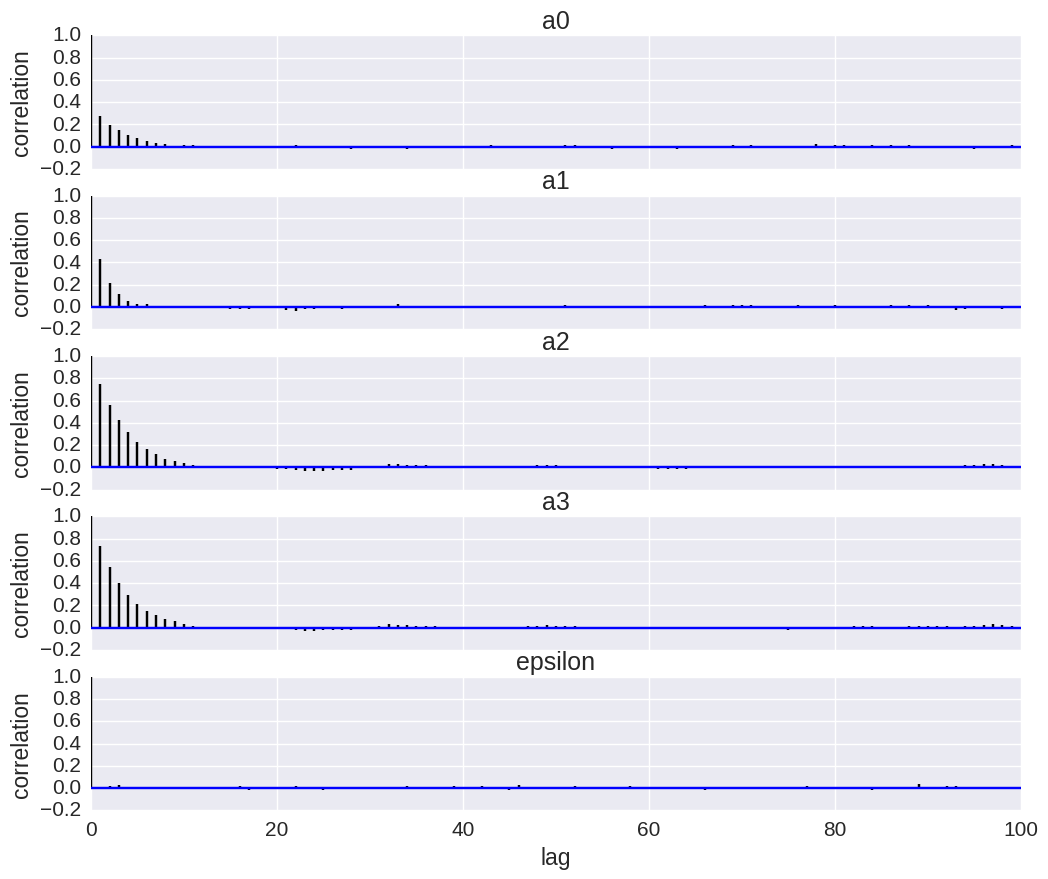

In [20]:
pm.autocorrplot(trace_ord3,varnames=varnames_o3);

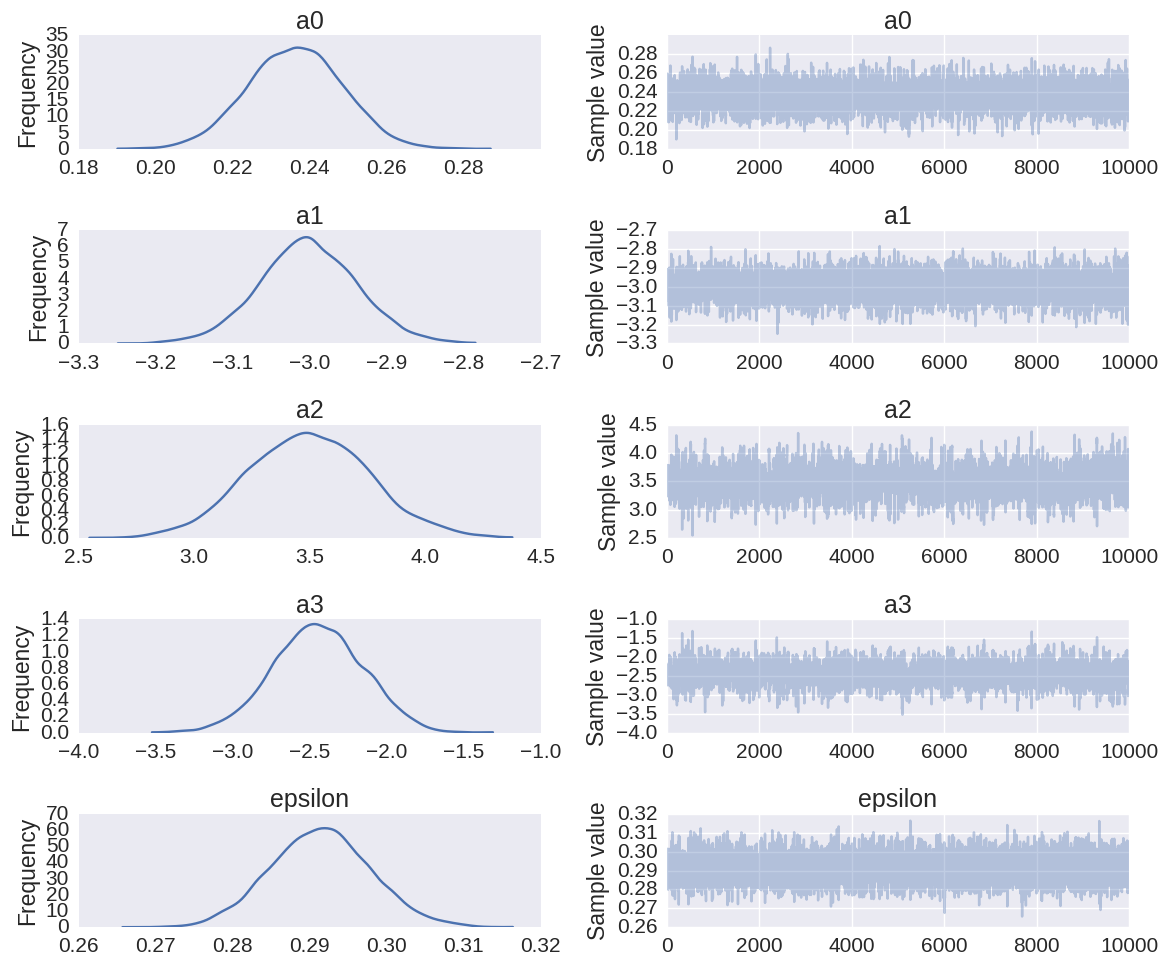

In [24]:
pm.traceplot(trace_ord3, varnames=varnames_o3, figsize=(12,10));

#### Parameter covariance

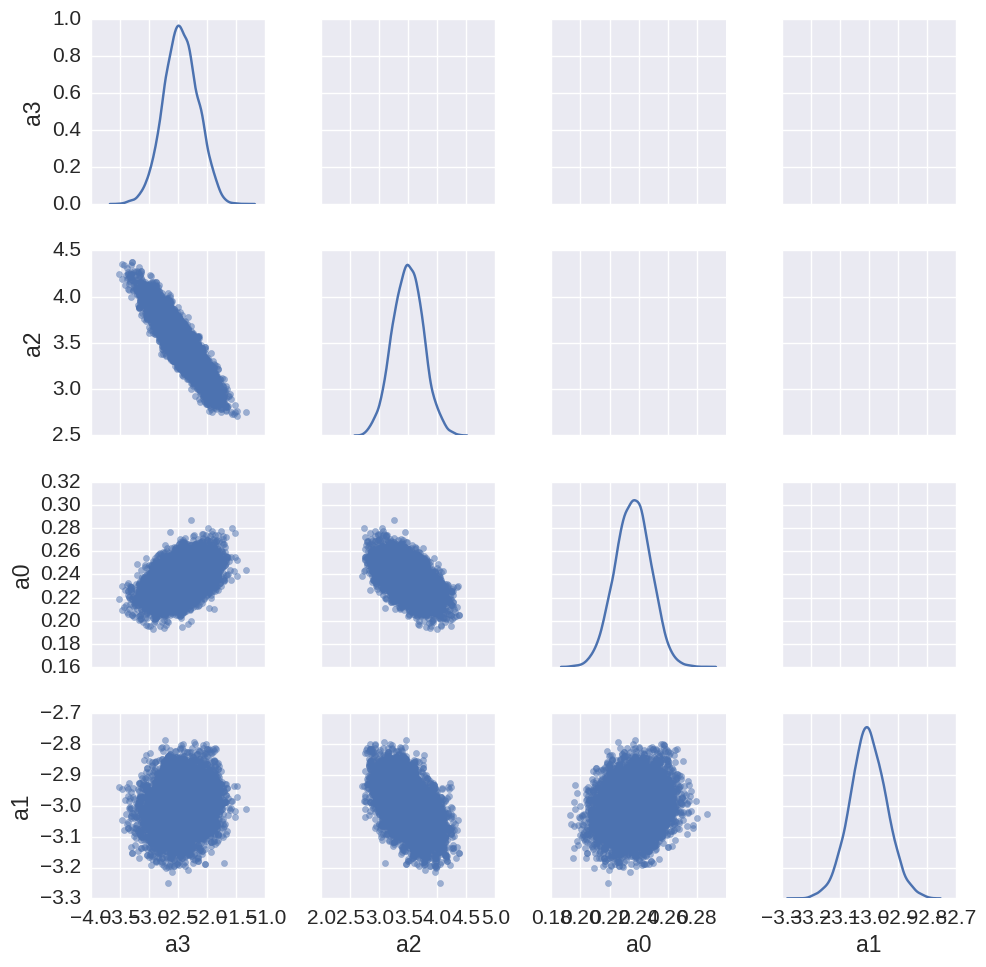

In [29]:
df_trace = pm.trace_to_dataframe(chain_ord3, 
                                 varnames=['a%d' %i for i in range(4)])
g = sb.PairGrid(df_trace, diag_sharey=False)
g = g.map_diag(sb.kdeplot)
g = g.map_lower(pl.scatter, alpha=0.5)

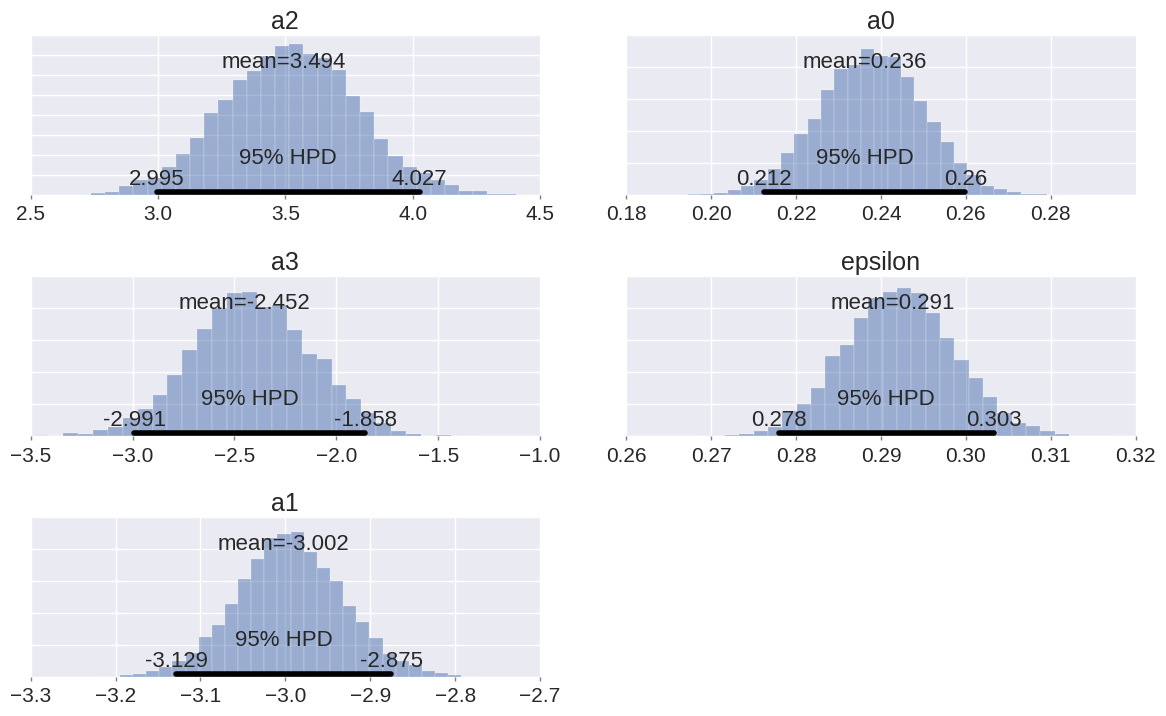

In [26]:
pm.plot_posterior(chain_ord3, varnames=varnames_o3, alpha=0.5);

#### Comparing Order 3 and Order 4 Polynomial Regression Outputs

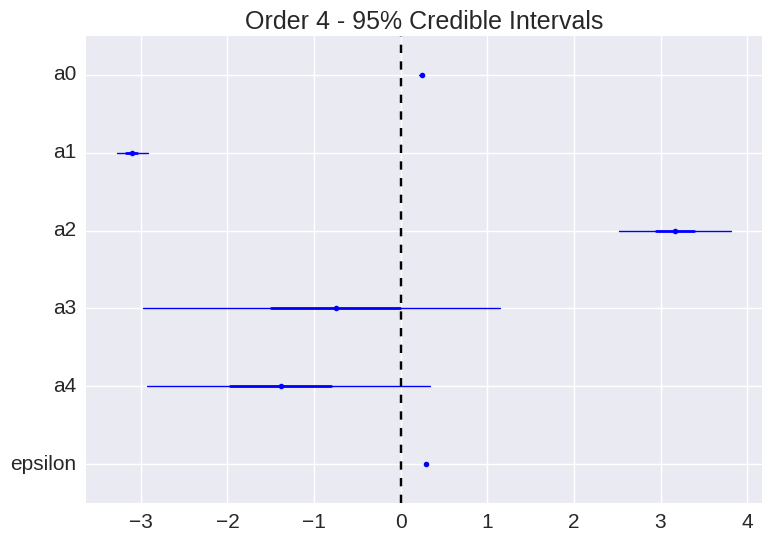

In [31]:
# Order 4
pm.forestplot(chain_ord4,varnames=varnames_o4, main='Order 4 - 95% Credible Intervals');

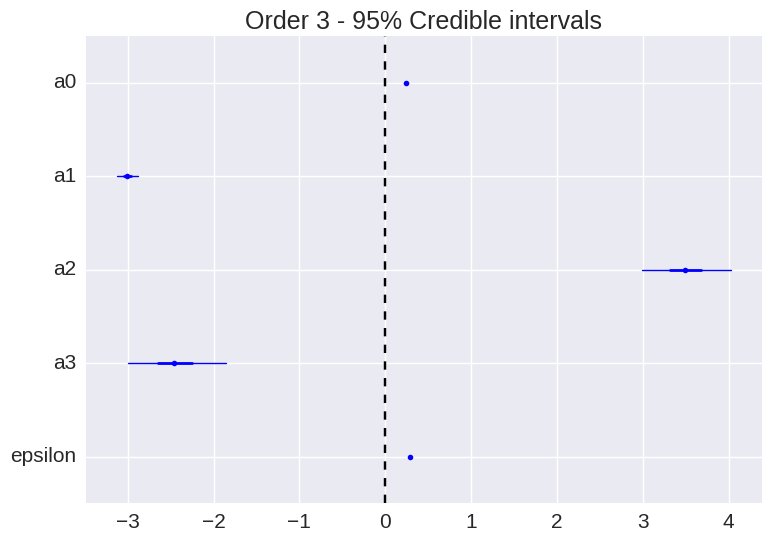

In [30]:
pm.forestplot(chain_ord3,varnames=varnames_o3, main='Order 3 - 95% Credible intervals');

The important point to notice above is that in the case of the order 4 polynomial regression, a3 and a4 straddle the '0' line with rather wide HDI's. This is not the case with any of the order 3 polynomial regression. 

### Model Comparisons:
#### Posterior Predictive Checks

In [46]:
sig0_ord4, sig1_ord4 = GetPPC(data=X_train, mcChain=chain_ord4, pmModel=OC4_ord4)
bayesCoeffs_ord4 = [chain_ord4['a%d' %i].mean() for i in range(5)]

100%|██████████| 1000/1000 [00:14<00:00, 66.73it/s]


In [56]:
sig0_ord3, sig1_ord3 = GetPPC(data=X_train, mcChain=chain_ord3, pmModel=OC4_ord3)
bayesCoeffs_ord3 = [chain_ord3['a%d' %i].mean() for i in range(4)]

100%|██████████| 1000/1000 [00:14<00:00, 70.05it/s]


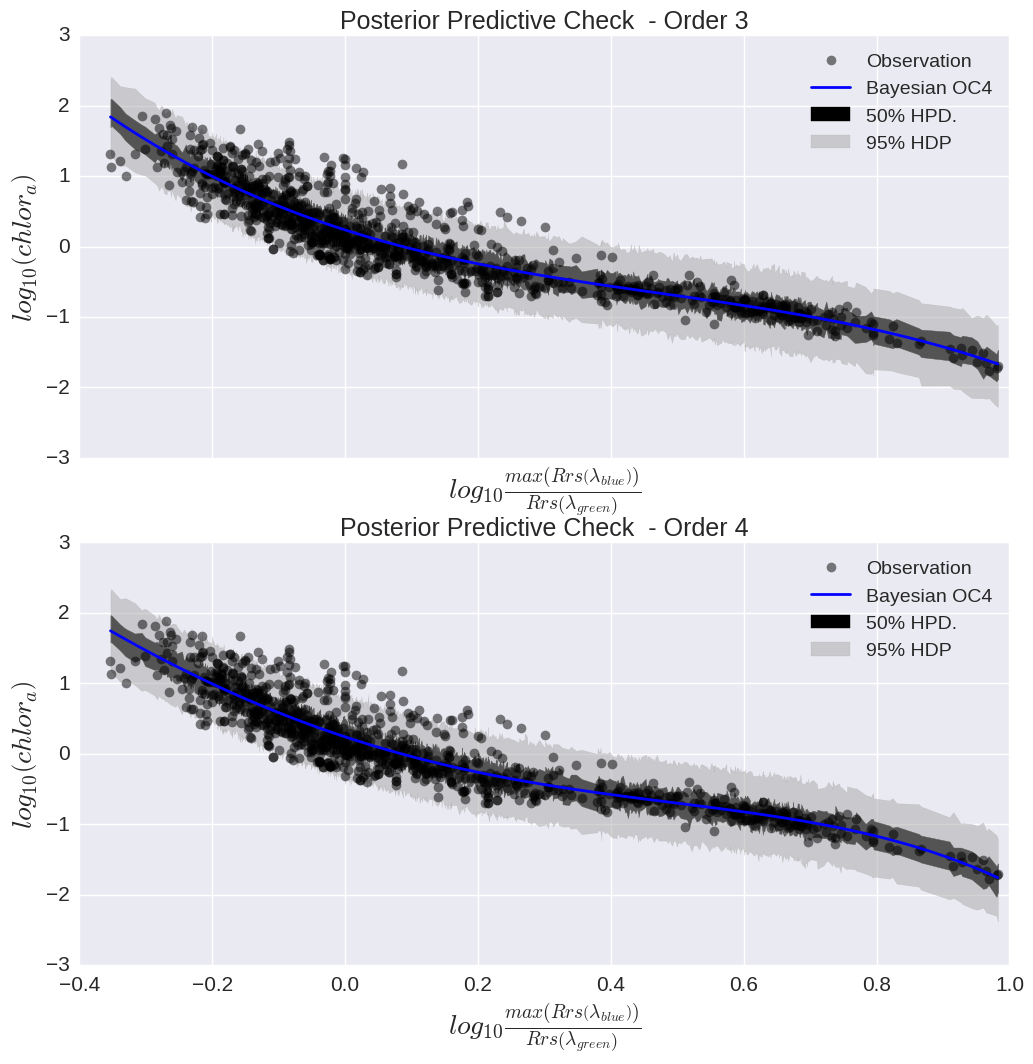

In [62]:
_,axs = pl.subplots(nrows=2, figsize=(12,12), sharex=True)
_ = PlotPPC(X_train, y_train, sig0_ord3, sig1_ord3, bayesCoeffs_ord3,ax=axs[0], title='PPC(Train) - Order 3')
_ = PlotPPC(X_train, y_train, sig0_ord4, sig1_ord4, bayesCoeffs_ord4,ax=axs[1], title='PPC(Train) - Order 4')

#### Deviance Information Criteria DIC


In [67]:
dic_3 = pm.dic(chain_ord3, model=OC4_ord3)
dic_4 = pm.dic(chain_ord4, model=OC4_ord4)

In [71]:
dic_3, dic_4

(413.65357426908332, 419.57522274874924)

So the Bayesian fit matches the least squares fit, as it should since I used uninformative (flat) priors. However, the Bayesian approach has also uncovered previously unavailable information about the components of the model and the model fit itself, in the form of uncertainties. These, I have expressed as credibility intervals around the coefficients, and the fit. This is not sufficient to validate a model however, as the model has not yet been tested on new data.

### Predicting Outcome from New Data
A machine learning practitioner who what (s)he's doing will want to apply the model to data that has not been used in the fitting process to assess the model's skill in real world predictions. The advantage in this particular case however is that in addition to prediction, we'll get uncertainties, not really available off the shelf with scikit-learn or other machine learning libraries. Even better, we can use the now familiar *posterior predictive checks* approach to do just that. 

As a reminder I framed the input data as a [theano shared variable](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables) to allow replacing the training data with the test data. The test data consists in SeaWiFS matchup data that originates, like NOMAD, from [SeaBASS](https://seabass.gsfc.nasa.gov/). However,  the data in this set was gathered after NOMAD was put together (2010 on) to avoid data leakage.

Another interesting aspect of this particular test data set is that because it's a matchup set it contains corresponding in situ and satellite measurements, which makes for an interesting performance comparison of the model.

In [74]:
# load test set
dfTest = pd.read_pickle('./bayesianChl_DATA/dfSwfChloraMups2010p.pkl')
dfTest.info()
dfLogTest = pd.DataFrame(columns=['id','seawifs_mxBl2Gr','insitu_chlor_a', 'seawifs_chlor_a'])
dfLogTest.id = dfTest.id
dfLogTest.seawifs_mxBl2Gr=  np.log10(dfTest.seawifs_mxBl2Gr)
dfLogTest.insitu_chlor_a = np.log10(dfTest.insitu_chlor_a)
dfLogTest.seawifs_chlor_a = np.log10(dfTest.seawifs_chlor_a)
X_test, y_test = dfLogTest.seawifs_mxBl2Gr.values, dfLogTest.insitu_chlor_a.values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 12 columns):
id                   59 non-null int64
latitude             59 non-null float64
longitude            59 non-null float64
date_time            59 non-null datetime64[ns]
cruise               59 non-null object
seawifs_solz         59 non-null float64
seawifs_senz         59 non-null float64
seawifs_windspeed    59 non-null float64
seawifs_tdiff        59 non-null int64
seawifs_mxBl2Gr      59 non-null float64
insitu_chlor_a       59 non-null float64
seawifs_chlor_a      59 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 5.6+ KB


In [75]:
# SUBSTITUTING TRAINING SET FOR TEST SET - CHANGING VALUES HERE WILL ALSO CHANGE VALUES IN THE MODEL
X_Shrd.set_value(X_test)

In [76]:
sig0_3Tst, sig1_3Tst = GetPPC(data=X_test, mcChain=chain_ord3, pmModel=OC4_ord3)

100%|██████████| 1000/1000 [00:15<00:00, 65.69it/s]


In [77]:
sig0_4Tst, sig1_4Tst = GetPPC(data=X_test, mcChain=chain_ord4, pmModel=OC4_ord4)

100%|██████████| 1000/1000 [00:15<00:00, 65.15it/s]


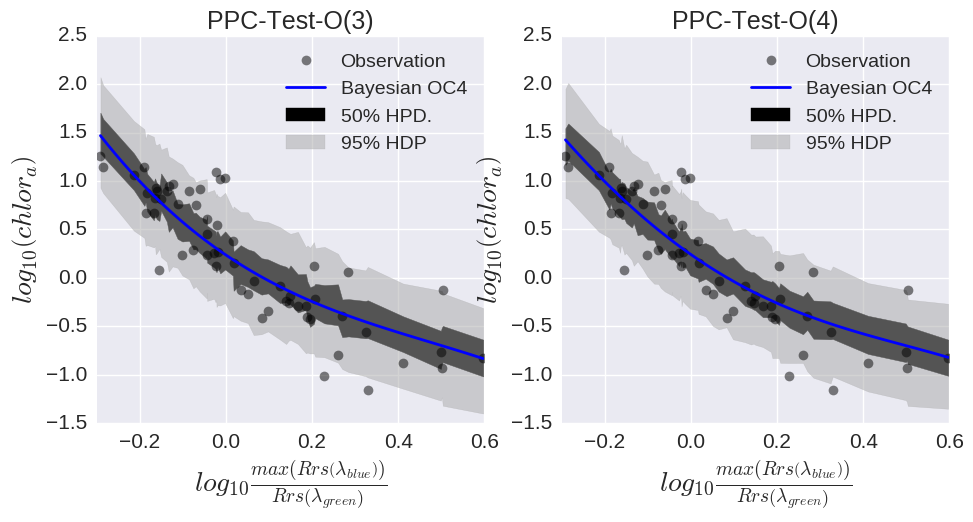

In [83]:
bayesCoeffs_3Tst = [chain_ord3['a%d' %i].mean() for i in range(4)]
bayesCoeffs_4Tst = [chain_ord4['a%d' %i].mean() for i in range(5)]

f,axs = pl.subplots(ncols=2, figsize=(11,5))
_ = PlotPPC(X_test, y_test, sig0_3Tst, sig1_3Tst, bayesCoeffs_3Tst, ax=axs[0], title='PPC-Test-O(3)')
_ = PlotPPC(X_test, y_test, sig0_4Tst, sig1_4Tst, bayesCoeffs_4Tst, ax=axs[1], title='PPC-Test-O(4)')

The above predictive checks on out-of-sample (test) data suggestss that the simpler O(3) polynomial regression does not perform much worse thant

In [90]:
OLS3Mdl= np.poly1d(ols3[::-1]) # encapsulate the fit results into a polynomial object
OLS4Mdl = np.poly1d(ols4[::-1]) 
y_test_pred_ols3 = OLS3Mdl(X_test) # evaluate polynomial with input data
y_test_pred_ols4 = OLS4Mdl(X_test)
y_test_pred_bay3 = 0
y_test_pred_bay4 = 0
for i in range(4):
    y_test_pred_bay3 += chain_ord3['a%d' %i].mean()*X_test**i
for i in range(5):
    y_test_pred_bay4 += chain_ord4['a%d' %i].mean()*X_test**i
print("mse, OLS3: %.2f " % mean_squared_error(y_test, y_test_pred_ols3))
print("mse, OLS4: %.2f " % mean_squared_error(y_test, y_test_pred_ols4))
print("mse, Bayes3: %.2f " % mean_squared_error(y_test, y_test_pred_bay3))
print("mse, Bayes4: %.2f " % mean_squared_error(y_test, y_test_pred_bay4))

mse, OLS3: 0.11 
mse, OLS4: 0.10 
mse, Bayes3: 0.11 
mse, Bayes4: 0.10 


So far, I've compared two different bayesian polynomial regressions, with a second simpler form justified by the examination of the marginals of the resulting posterior distribution. I'v also briefly touched on bayesian model comparison. That's it for this exercise, but that's not it for this dataset. There is likely some uncertainty introduced by the origin and type of data used. In a subsequent post, I'll use that as an excuse to explore the recasting of this model into a hierarchical framework. Until then, happy hacking!